In [1]:
import numpy as np
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.api import WavefunctionSimulator
from pyquil.unitary_tools import lifted_pauli
from pyquil import Program
from pyquil.gates import H, RX, RZ


from time import time
from entropica_qaoa.vqe.cost_function import PrepareAndMeasureOnWFSim

sim = WavefunctionSimulator()

In [10]:
def runtime_func(n_qubits, upper_lim):
    
    """
    n_qubits is total number of qubits
    
    builds a ZZ cost Hamiltonian with all terms of form Z_i*Z_j from i = 0, j = 1 up to
    i = upper_lim-1, j = upper_lim 
    """
    
    ham = []
    for i in range(upper_lim-1):
        for j in range(i+1,upper_lim):

            term = PauliTerm("Z", i, np.random.rand())*PauliTerm("Z", j) 
            ham.append(term)

    ham = PauliSum(ham)
    
    n_terms = len(ham.terms) # total number of terms in the PauliSum
    
    # Build a QAOA-like circuit - not really important here
    prepare_prog = Program()
    for i in range(n_qubits):    
        prepare_prog.inst(H(i))
    
    for i in range(n_qubits):
        prepare_prog.inst(RZ(np.random.rand(),i))
    
    for i in range(n_qubits):
        prepare_prog.inst(RX(np.random.rand(),i))
    
    # time taken to run on Rigetti QVM
    start_exp = time()
    Expval1 = sim.expectation(prepare_prog, ham)
    end_exp = time()

    # time taken to run in EntropicaQAOA
    start_new = time()
    cost_fun = PrepareAndMeasureOnWFSim(prepare_prog,lambda x:{}, ham,sim)
    cost_fun([])
    end_new = time()
    
    # time taken to run using matrices
    start_matr = time()
    wavefunc = sim.wavefunction(prepare_prog).amplitudes
    ham_matrix = lifted_pauli(ham, np.arange(n_qubits))
    Expval2 = np.vdot(wavefunc, np.dot(ham_matrix,wavefunc))
    end_matr = time()
    
    duration_exp = end_exp - start_exp
    duration_new = end_new - start_new
    duration_matr = end_matr - start_matr
    
    return n_terms, duration_exp, duration_matr, duration_new

In [11]:
n_qubits = 10
upper_lim = np.arange(3,n_qubits +1)

runtime_exp = np.zeros(len(upper_lim))
runtime_matr = np.zeros(len(upper_lim))
runtime_new = np.zeros(len(upper_lim))
n_terms = np.zeros(len(upper_lim))
for i in range(len(upper_lim)):

    terms_, time_exp, time_matr, time_new = runtime_func(n_qubits, upper_lim[i])

    n_terms[i] = terms_
    runtime_exp[i] = time_exp
    runtime_matr[i] = time_matr
    runtime_new[i] = time_new

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 8 is different from 1024)

In [5]:
import matplotlib.pyplot as plt

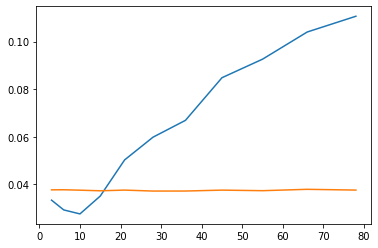

In [14]:
plt.plot(n_terms,runtime_exp, n_terms, runtime_matr)
plt.show()